In [30]:
import numpy as np
import pandas as pd

from mesa.space import SingleGrid
from tqdm import tqdm

def create_grid(x, y):
    grid = SingleGrid(x, y, True)
    
    return grid

def neighborhood(x, y, X, Y, radius = 3):
    '''
    x_tbl, y_tbl and neighbor functions from original
    '''
    x_conv = x + np.concatenate([np.arange(-radius,radius + 1)[np.newaxis, :]] * (2 * radius + 1), axis = 0) % X
    y_conv = y + np.concatenate([np.arange(-radius,radius + 1)[:, np.newaxis]] * (2 * radius + 1), axis = 1) % Y
    
    return [(a, b) for a, b in zip(x_conv.flatten(), y_conv.flatten()) if (a != x) or (b != y)]

def make_network(grid, target_degree, neighbor_frac, seed = None, radius = 3):
    '''
    Replaces the network function from the original code. Uses built in get_neighborhood from mesa. 
    Returns transition matrix T instead of a df of neighbors, which is more akin to the original code. 
    Also uses helper funcs to_coord and to_index, defined within the scope of the function. 
    Should check the order of agents in the grid, confirm the helpers are indexing correctly. 
    Grid only exists to get neighborhood. 
    '''
    
    grid_x = grid.width
    grid_y = grid.height
    
    #Returns 0 - X as x coordinate. Indexing is done in row order
    to_coord = lambda x, X: (x % X, x // X)
    #goes over y rows, then adds x
    to_index = lambda x, X, y: x + y * X
    
    n = grid.height * grid.width
    
    links = 0
    avg_degree = 0
    T = np.zeros((n, n))
    pairs = []
    
    np.random.seed(seed)
    
    while avg_degree < target_degree:
        c1 = np.random.randint(n)
        c1_coords = to_coord(c1, grid_x)
        neighs = grid.get_neighborhood(c1_coords, True, include_center = False, radius = radius)
        neigh_inds = [to_index(x, grid_x, y) for x, y in neighs]
        if np.random.rand() < neighbor_frac:
            pots = neigh_inds
        else:
            neigh_incl = neigh_inds + [c1]
            pots = [x for x in range(n) if x not in neigh_incl]
            
        c2 = np.random.choice(pots)
        if T[c1, c2] == 0:
            pairs.append((c1, c2))
            T[c1, c2] = 1
            T[c2, c1] = 1
            links += 2
            avg_degree = links/n
            if links % 10000 == 0:
                print(links)
                
    return T, pairs

grid = SingleGrid(7, 7, True)
T, pairs = make_network(grid, 10, 0.3, radius = 1)

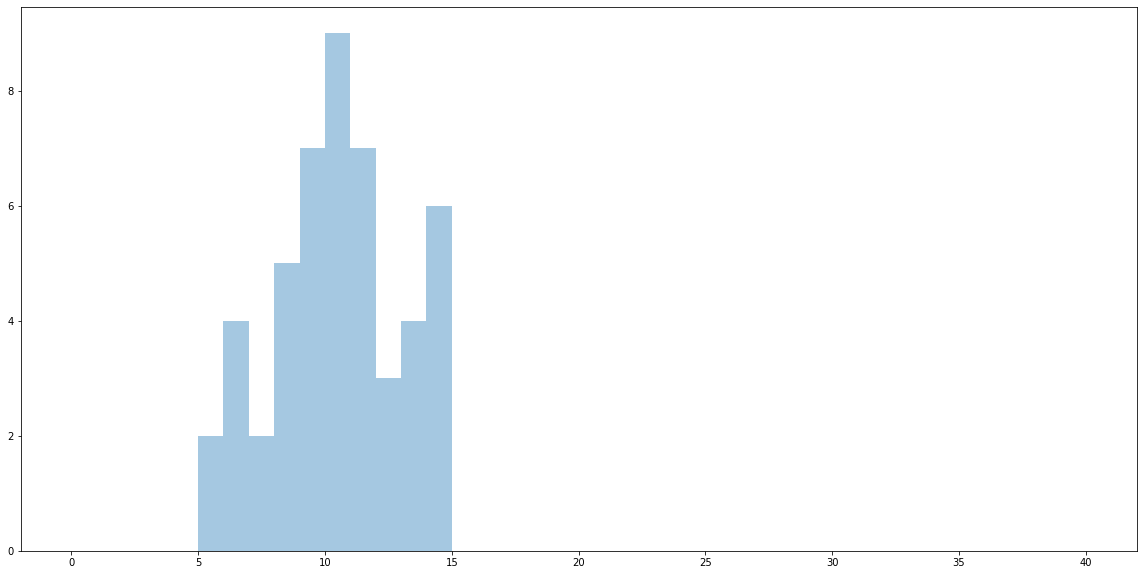

In [31]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize = (20, 10))

bins = np.linspace(0, 40, num = 41)
sns.distplot(T.sum(axis = 1), bins = bins, kde = False)

In [32]:
def assign_types(grid, stigma_frac, conform_frac):
    '''
    Replaces typestatus function in the original code. 
    Instead of using 0, 1, 2 as our types we use the written form.
    0 : Conformist, 1 : Stigmatized, 2 : Compassionate
    '''
    n = grid.height * grid.width
    stigs = np.random.choice(n, int(n * stigma_frac), replace = False)
    non_stigs = np.array([x for x in range(n) if x not in stigs])
    
    confs = np.random.choice(non_stigs, int(len(non_stigs) * conform_frac), replace = False)
    
    types = pd.DataFrame(index = np.arange(n))
    types['Type'] = 'Compassionate'
    types.loc[confs, 'Type'] = 'Conformist'
    types.loc[stigs, 'Type'] = 'Stigmatized'
    
    return types

def initial_status(revealed_frac, accepting_frac, types, threshs):
    '''
    Handles the initialization portion of the original evolve function. 
    '''
    stigs = types.query('Type == "Stigmatized"')
    others = types.query('Type != "Stigmatized"')
    
    revealed = np.random.choice(stigs.index, int(revealed_frac * len(stigs)), replace = False)
    accepting = np.random.choice(others.index, int(accepting_frac * len(others)), replace = False)
    
    types['Status'] = False
    types.loc[revealed, 'Status'] = True
    types.loc[accepting, 'Status'] = True
    types['Thresh'] = types['Type'].map(threshs)
    
    return types
    
types = assign_types(grid, 0.1, 0.3)
types = initial_status(0.15, 0.05, types, {'Compassionate' : 0.05, 'Stigmatized' : 0.4, 'Conformist' : 0.3})
types['N_Neighbors'] = T.sum(axis = 1)
types['N_Convert'] = types['N_Neighbors'] * types['Thresh']
types.head()

,Type,Status,Thresh,N_Neighbors,N_Convert
0,Stigmatized,False,0.40,14.0,5.60
1,Compassionate,False,0.05,13.0,0.65
2,Compassionate,False,0.05,11.0,0.55
3,Compassionate,False,0.05,8.0,0.40
4,Stigmatized,False,0.40,12.0,4.80


In [33]:
types.groupby('Type')['Status'].sum()

Type
Compassionate     True
Conformist        True
Stigmatized      False
Name: Status, dtype: bool

In [37]:
def step(init_info, T, status):
    '''
    Individual iteration of the main loop in evolve. 
    '''
    
    stigs = init_info.query('Type == "Stigmatized"').index
    comps = init_info.query('Type == "Compassionate"').index
    
    acc_neighbors = T @ status
    rev_neighbors = T[:, stigs] @ status[stigs]
    
    num_eff = acc_neighbors.copy()
    num_eff[comps] = rev_neighbors[comps]
    
    new_status = num_eff >= init_info['N_Convert']
    # For stigmatized, if already revealed they won't go back. 
    new_status[stigs] = np.logical_or(status[stigs], new_status[stigs])
    
    return new_status

ret = step(types, T, types['Status'])

0    True
1    True
2    True
3    True
Name: N_Convert, dtype: bool

In [84]:
def log_single(init_info, status, i, aggs, states):
    state = pd.concat([init_info, status], axis = 1)
    cts = state.groupby('Type')['New_Status'].sum()
    cts.name = i
    
    s = status.copy()
    s.name = i
    
    aggs.append(cts)
    states.append(s)
    
    return cts
    

def run_simulation(time, init_info, T):
    aggs = []
    states = []
    
    new_status = init_info['Status'].copy()
    new_status.name = 'New_Status'
    
    log_single(init_info, new_status, 0, aggs, states)
    
    for i in tqdm(range(time)):
        new_status = pd.Series(step(init_info, T, new_status), name = 'New_Status')
        log_single(init_info, new_status, i + 1, aggs, states)
        
    return aggs, states

test_init = pd.DataFrame({'Type' : ['Conformist', 'Stigmatized', 'Conformist', 'Compassionate', 'Conformist', 'Conformist', 'Conformist', 'Stigmatized', 'Compassionate'], 
                         'N_Convert' : [2, 1, 1, 1, 1, 1, 1, 1, 1], 
                         'Status' :  [1, 0, 0, 0, 0, 0, 0, 0, 0]})
test_T = np.array([[0, 0, 1, 1, 0, 0, 0, 0, 0], 
                  [0, 0, 1, 1, 0, 0, 0, 0, 0], 
                  [1, 1, 0, 0, 0, 0, 0, 0, 0], 
                  [1, 1, 0, 0, 1, 0, 0, 0, 0], 
                  [0, 0, 0, 1, 0, 1, 0, 0, 0], 
                  [0, 0, 0, 0, 1, 0, 1, 0, 0], 
                  [0, 0, 0, 0, 0, 1, 0, 1, 0], 
                  [0, 0, 0, 0, 0, 0, 1, 0, 1], 
                  [0, 0, 0, 0, 0, 0, 0, 1, 0]])
aggs, states = run_simulation(8, test_init, test_T)

100%|██████████| 8/8 [00:00<00:00, 169.77it/s]


In [85]:
types.groupby('Type').count()

,Status,Thresh,N_Neighbors,N_Convert
Type,,,,
Compassionate,32,32,32,32
Conformist,13,13,13,13
Stigmatized,4,4,4,4


In [86]:
pd.concat(aggs, axis = 1)

,0,1,2,3,4,5,6,7,8
Type,,,,,,,,,
Compassionate,0,False,False,True,1.0,1.0,1.0,1.0,2.0
Conformist,1,True,False,True,3.0,4.0,5.0,5.0,5.0
Stigmatized,0,False,True,True,1.0,1.0,1.0,2.0,2.0


In [87]:
T.shape

(49, 49)

In [88]:
(test_T @ pd.concat(states, axis = 1)).apply(lambda x: x >= test_init['N_Convert'])

,0,1,2,3,4,5,6,7,8
0,False,False,False,True,True,True,True,True,True
1,False,True,False,True,True,True,True,True,True
2,True,False,True,True,True,True,True,True,True
3,True,False,True,True,True,True,True,True,True
4,False,False,False,True,True,True,True,True,True
5,False,False,False,False,True,True,True,True,True
6,False,False,False,False,False,True,True,True,True
7,False,False,False,False,False,False,True,True,True
8,False,False,False,False,False,False,False,True,True


In [89]:
test_T @ pd.concat(states, axis = 1)

,0,1,2,3,4,5,6,7,8
0,0,1,0,2,2,2,2,2,2
1,0,1,0,2,2,2,2,2,2
2,1,0,1,1,2,2,2,2,2
3,1,0,1,1,3,3,3,3,3
4,0,0,0,1,1,2,2,2,2
5,0,0,0,0,1,1,2,2,2
6,0,0,0,0,0,1,1,2,2
7,0,0,0,0,0,0,1,1,2
8,0,0,0,0,0,0,0,1,1


In [90]:
pd.concat(states, axis = 1)

,0,1,2,3,4,5,6,7,8
0,1,False,False,False,True,True,True,True,True
1,0,False,True,True,True,True,True,True,True
2,0,True,False,True,True,True,True,True,True
3,0,False,False,True,True,True,True,True,True
4,0,False,False,False,True,True,True,True,True
5,0,False,False,False,False,True,True,True,True
6,0,False,False,False,False,False,True,True,True
7,0,False,False,False,False,False,False,True,True
8,0,False,False,False,False,False,False,False,True


In [91]:
test2 = pd.DataFrame({'Type' : ['Conformist', 'Conformist'], 
                     'N_Convert' : [1, 1], 
                     'Status' : [1, 0]})

T2 = np.array([[0, 1], [1, 0]])

aggs, states = run_simulation(8, test2, T2)
pd.concat(states, axis = 1)

100%|██████████| 8/8 [00:00<00:00, 180.29it/s]


,0,1,2,3,4,5,6,7,8
0,1,False,True,False,True,False,True,False,True
1,0,True,False,True,False,True,False,True,False
